In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-cancer-mri-dataset/dataset.csv
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor/brain_tumor_1402.jpg
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor/brain_tumor_0483.jpg
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor/brain_tumor_0141.jpg
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor/brain_tumor_1531.jpg
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor/brain_tumor_0285.jpg
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor/brain_tumor_0062.jpg
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor/brain_tumor_1891.jpg
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/brain_tumor/brain_tumor_1322.jpg
/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI d

In [3]:
import torch
import torch.nn as nn  # Fixed: Added this import
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os

class LeNet5(nn.Module):
    def __init__(self, num_classes=4):
        super(LeNet5, self).__init__()  
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)  
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(in_features=16*59*59, out_features=120)
        self.dropout1 = nn.Dropout(0.5)  # Added dropout
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.dropout2 = nn.Dropout(0.5)  # Added dropout
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
     x = F.relu(self.conv1(x))
     x = self.pool1(x)
     x = F.relu(self.conv2(x))
     x = self.pool2(x)
     x = x.view(x.size(0), -1)  # Flatten the tensor
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = self.fc3(x)
     return x




In [4]:
import os
data_dir = '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer'
print(os.listdir(data_dir))

['brain_tumor', 'brain_glioma', 'brain_menin']


In [5]:
model = LeNet5(num_classes=3)

In [6]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Add data augmentation to the transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Randomly flip images
    transforms.RandomRotation(10),      # Augmentation: Randomly rotate by ±10 degrees
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the dataset with the defined transformations
dataset = ImageFolder(root=data_dir, transform=transform)
print(dataset.classes)


['brain_glioma', 'brain_menin', 'brain_tumor']


In [7]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size
train_dataset , test_dataset = random_split(dataset, [train_size,test_size])
batch_size = 16
train_loader = DataLoader(train_dataset,batch_size=batch_size ,shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size,shuffle=False)


torch.Size([16, 1, 244, 244])


In [9]:
num_classes = len(dataset.classes) 
model = LeNet5(num_classes=num_classes)
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=55696, out_features=120, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [10]:
with torch.no_grad():
    output= model(images)
    print(output.shape)

torch.Size([16, 3])


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.1)
# Training loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    best_test_acc = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Evaluation phase
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    scheduler.step(test_acc)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/lenet5_brain_cancer_best.pth')
        print("Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
# Save the trained model
torch.save(model.state_dict(), '/kaggle/working/lenet5_brain_cancer.pth')
print("Model saved to /kaggle/working/lenet5_brain_cancer.pth")

Using device: cuda
Epoch [1/10] - Train Loss: 0.6115, Train Acc: 76.96%
Test Accuracy: 80.61%
Best model saved!
Epoch [2/10] - Train Loss: 0.5106, Train Acc: 80.47%
Test Accuracy: 82.67%
Best model saved!
Epoch [3/10] - Train Loss: 0.4867, Train Acc: 81.23%
Test Accuracy: 85.40%
Best model saved!
Epoch [4/10] - Train Loss: 0.4853, Train Acc: 81.36%
Test Accuracy: 79.70%
Best model saved!
Epoch [5/10] - Train Loss: 0.4145, Train Acc: 85.30%
Test Accuracy: 85.31%
Best model saved!
Epoch [6/10] - Train Loss: 0.3318, Train Acc: 87.57%
Test Accuracy: 87.62%
Best model saved!
Epoch [7/10] - Train Loss: 0.3155, Train Acc: 88.63%
Test Accuracy: 80.94%
Best model saved!
Epoch [8/10] - Train Loss: 0.2920, Train Acc: 89.41%
Test Accuracy: 87.13%
Best model saved!
Epoch [9/10] - Train Loss: 0.2800, Train Acc: 89.66%
Test Accuracy: 84.74%
Best model saved!
Epoch [10/10] - Train Loss: 0.2573, Train Acc: 90.32%
Test Accuracy: 89.03%
Best model saved!
Model saved to /kaggle/working/lenet5_brain_cancer

Class names: ['brain_glioma', 'brain_menin', 'brain_tumor']


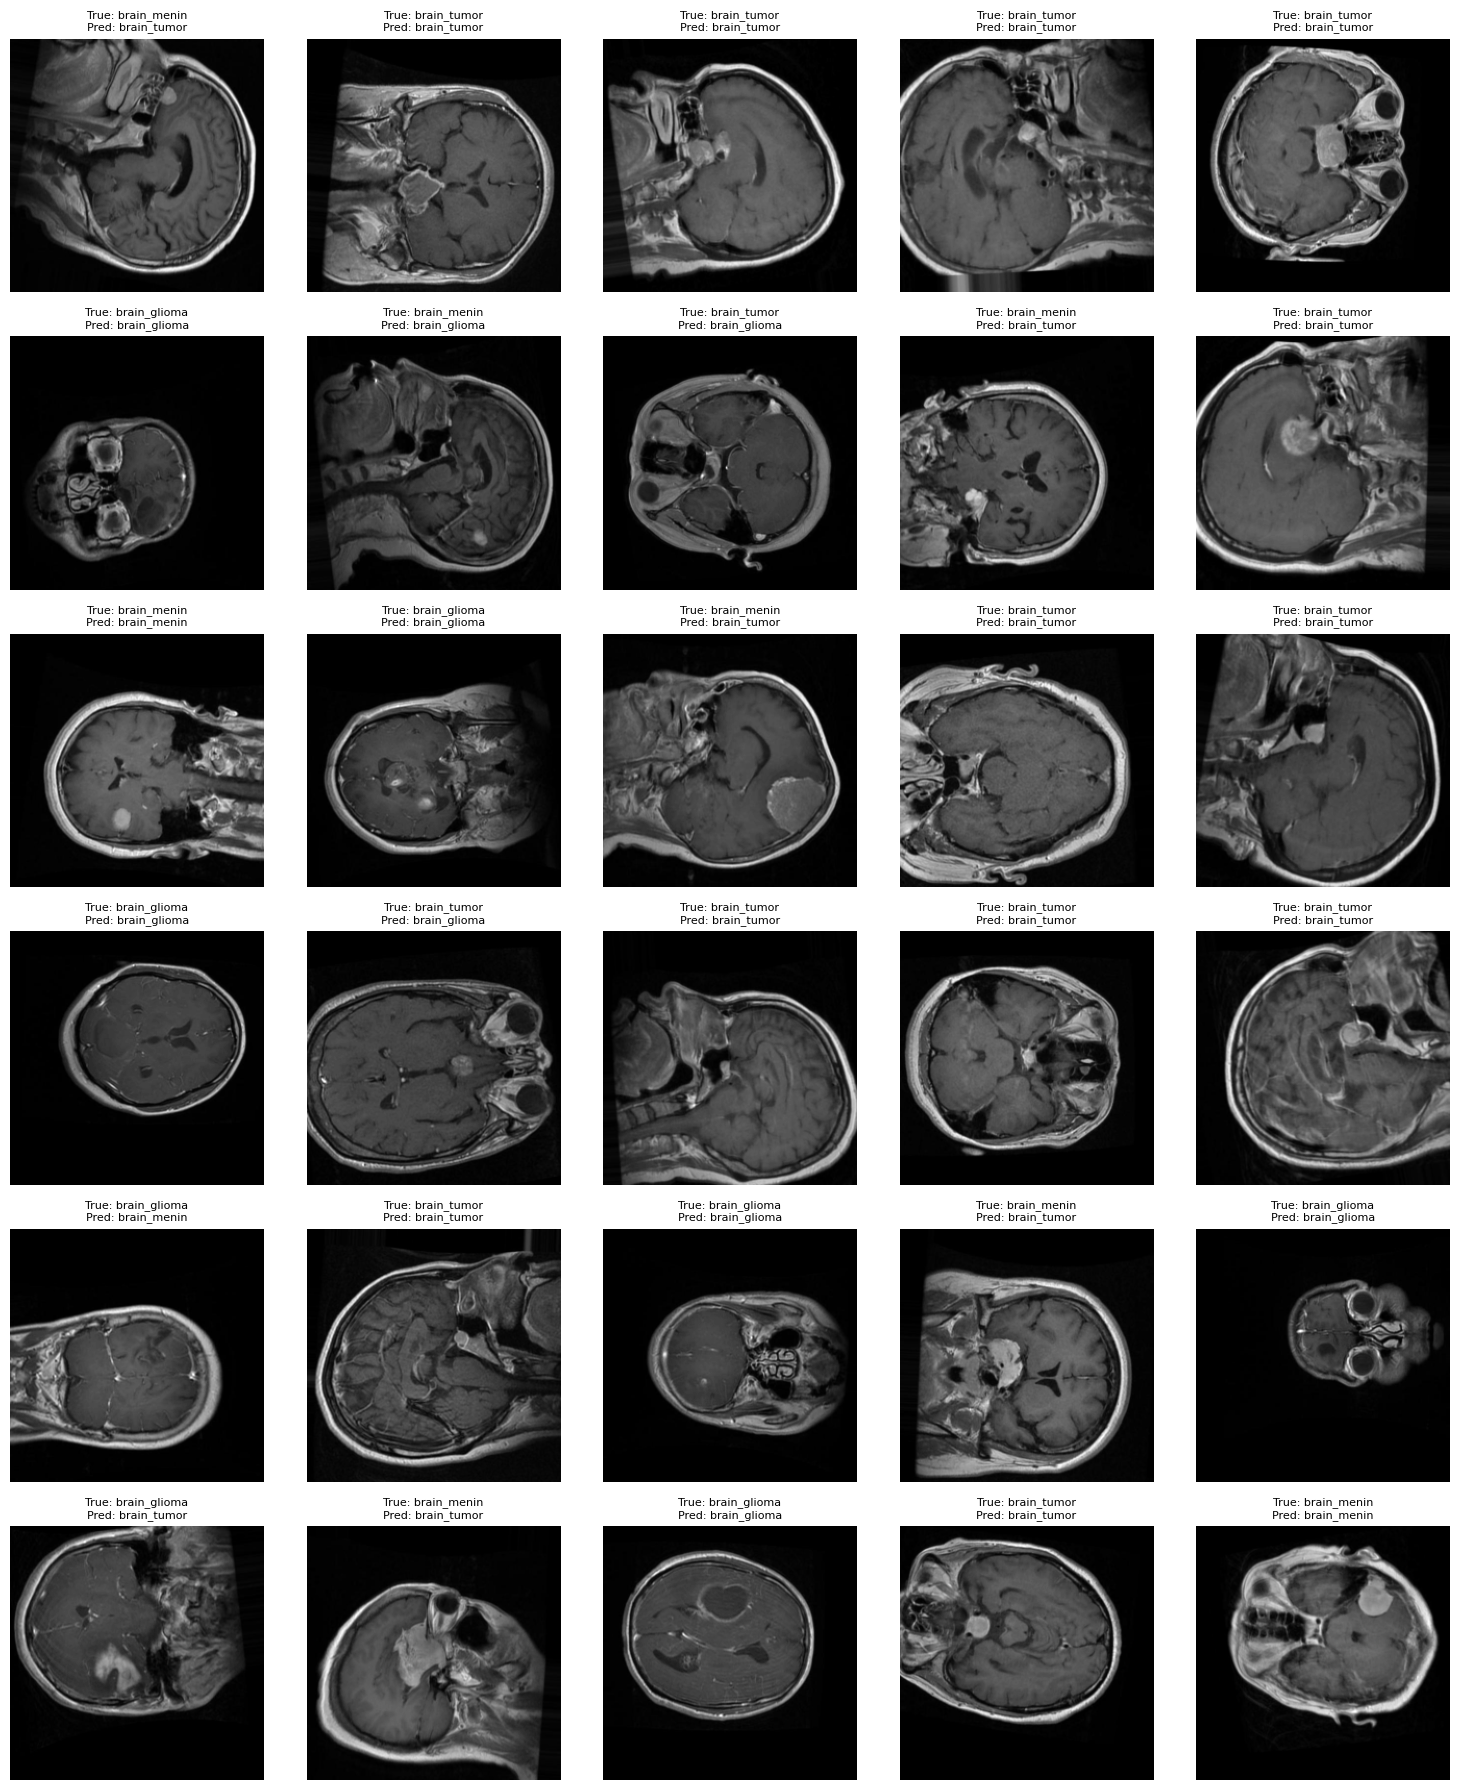

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define class_names (get from test_dataset)
class_names = test_loader.dataset.dataset.classes  # E.g., ['brain_glioma', 'brain_menin', 'brain_tumor']
print("Class names:", class_names)

# Function to unnormalize image for visualization
def unnormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization: (img * std) + mean
    return img

# Collect 30 images and their predictions
images_to_show = []
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Fixed: Added (outputs, 1) to get max indices
        
        # Move to CPU and store
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()
        
        images_to_show.extend(images)
        true_labels.extend(labels)
        pred_labels.extend(predicted)
        
        if len(images_to_show) >= 30:  # Stop after collecting 30 images
            break

# Display 30 images in a 6x5 grid
plt.figure(figsize=(15, 18))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    img = unnormalize(images_to_show[i]).numpy().squeeze()  # Remove channel dimension for grayscale
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", fontsize=8)
    plt.axis('off')  # Ensure axis is hidden
plt.tight_layout()
plt.show()

In [22]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=2),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  
            
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), 
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.6),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)  
        x = self.classifier(x)
        return x

num_classes = len(train_dataset.dataset.classes)  
model = AlexNet(num_classes=num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

torch.cuda.empty_cache()


Using device: cuda


In [19]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)  # Lower lr for deeper model
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=4, factor=0.5)

num_epochs = 20
best_test_acc = 0.0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_acc = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")

    scheduler.step(test_acc)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/alexnet_brain_cancer_best.pth')
        print("Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load('/kaggle/working/alexnet_brain_cancer_best.pth', weights_only=True))
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_test_acc = 100 * test_correct / test_total
print(f"Final Test Accuracy with Best Model: {final_test_acc:.2f}%")

Epoch [1/20] - Train Loss: 0.8036, Train Acc: 62.22%
Test Accuracy: 73.76%
Best model saved!
Epoch [2/20] - Train Loss: 0.5807, Train Acc: 76.24%
Test Accuracy: 79.04%
Best model saved!
Epoch [3/20] - Train Loss: 0.5021, Train Acc: 80.08%
Test Accuracy: 78.63%
Epoch [4/20] - Train Loss: 0.4564, Train Acc: 82.31%
Test Accuracy: 82.34%
Best model saved!
Epoch [5/20] - Train Loss: 0.4053, Train Acc: 84.72%
Test Accuracy: 85.15%
Best model saved!
Epoch [6/20] - Train Loss: 0.3669, Train Acc: 86.25%
Test Accuracy: 87.62%
Best model saved!
Epoch [7/20] - Train Loss: 0.3019, Train Acc: 88.36%
Test Accuracy: 84.82%
Epoch [8/20] - Train Loss: 0.2587, Train Acc: 90.40%
Test Accuracy: 90.68%
Best model saved!
Epoch [9/20] - Train Loss: 0.2067, Train Acc: 92.36%
Test Accuracy: 89.93%
Epoch [10/20] - Train Loss: 0.1679, Train Acc: 93.62%
Test Accuracy: 91.09%
Best model saved!
Epoch [11/20] - Train Loss: 0.1381, Train Acc: 94.98%
Test Accuracy: 92.82%
Best model saved!
Epoch [12/20] - Train Loss: 0

Class names: ['brain_glioma', 'brain_menin', 'brain_tumor']


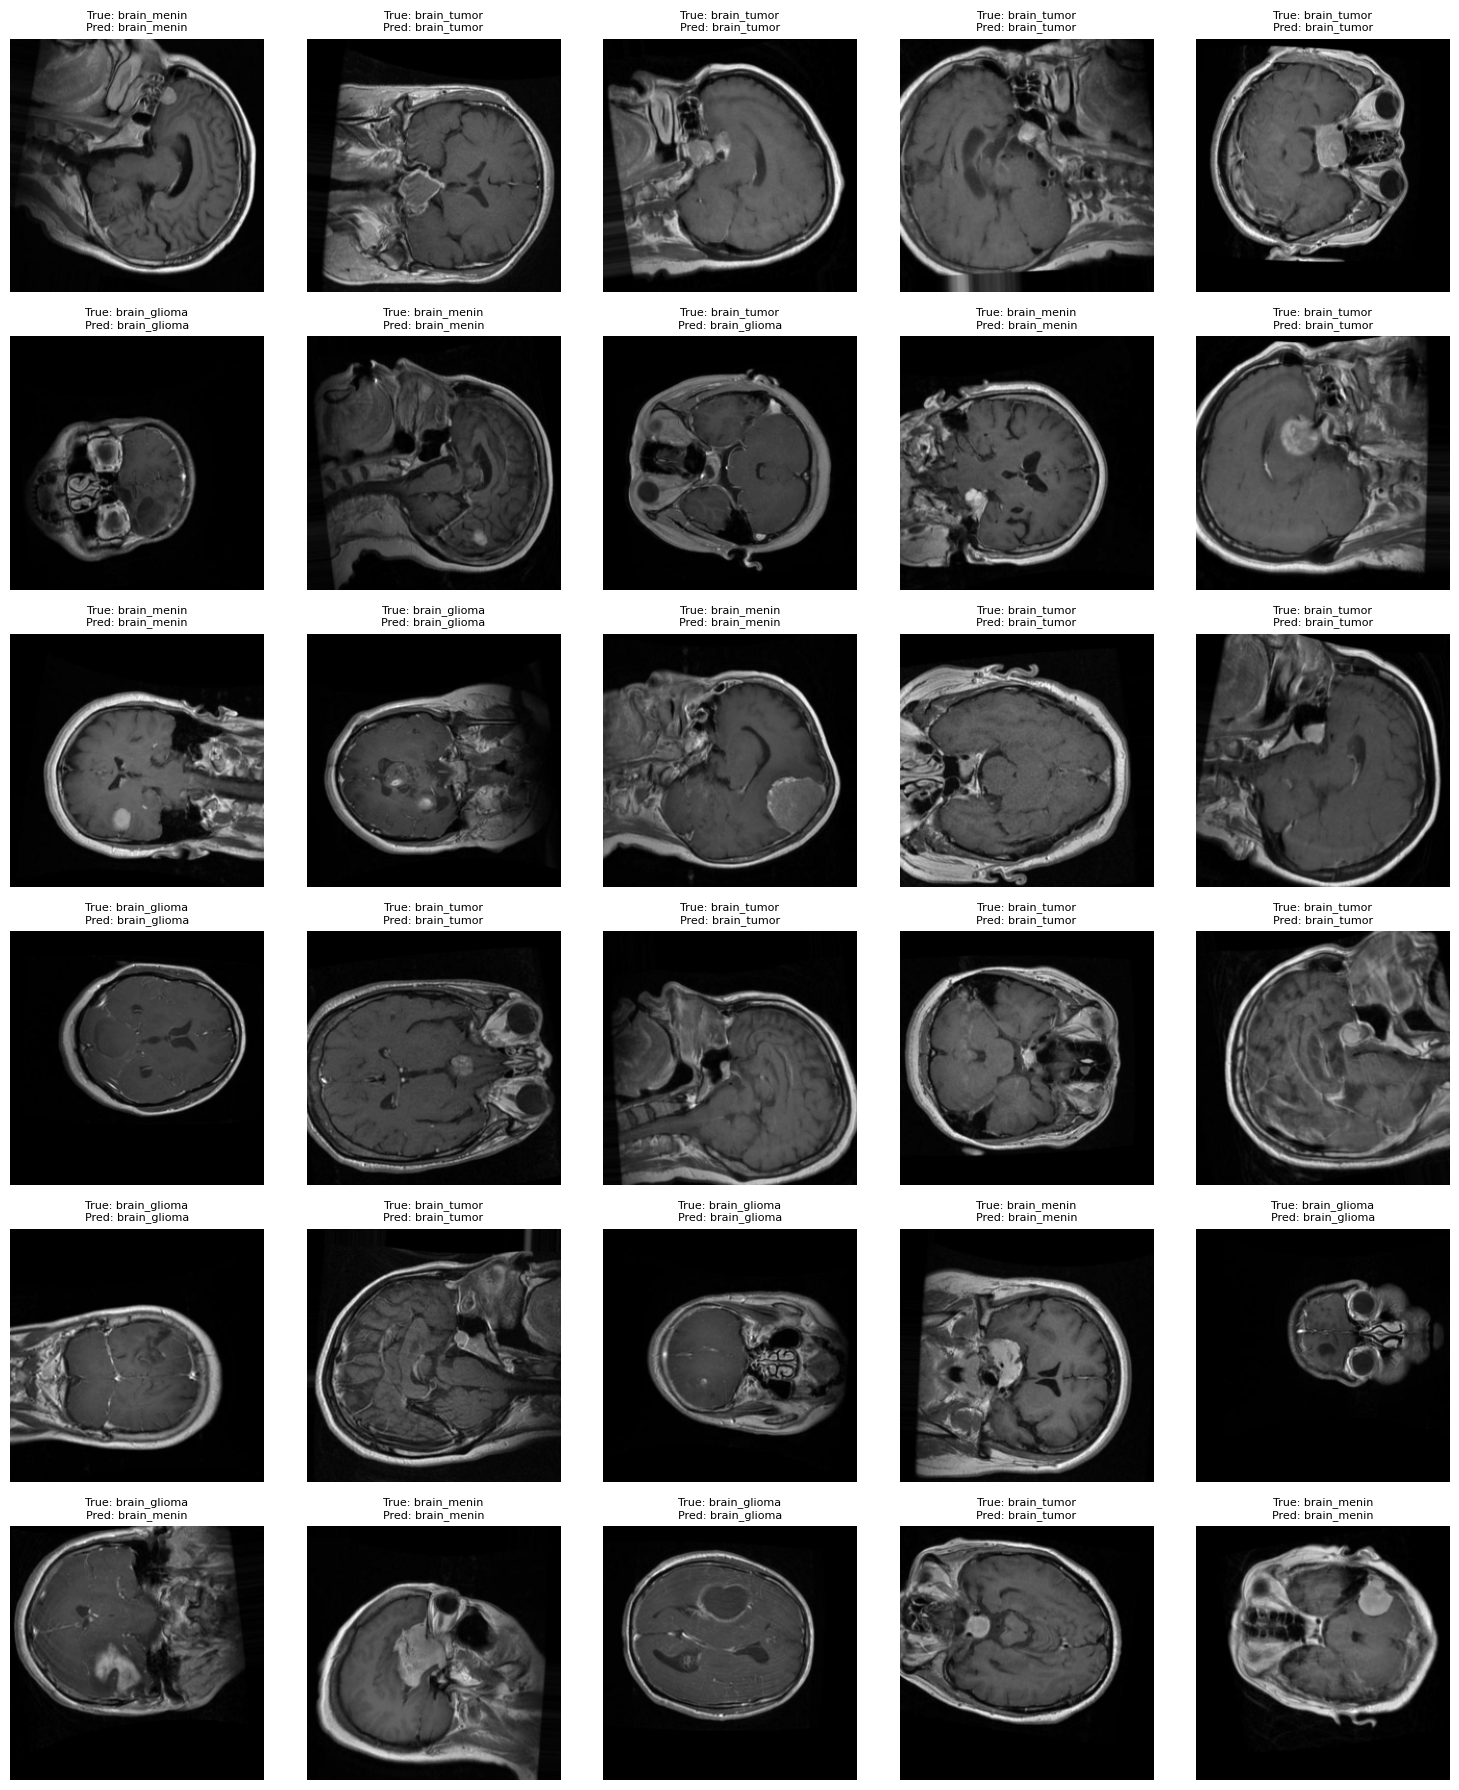

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

modelalex = AlexNet(num_classes=3).to(device)
modelalex.load_state_dict(torch.load('/kaggle/working/alexnet_brain_cancer_best.pth', weights_only=True))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define class_names (get from test_dataset)
class_names = test_loader.dataset.dataset.classes  # E.g., ['brain_glioma', 'brain_menin', 'brain_tumor']
print("Class names:", class_names)

# Function to unnormalize image for visualization
def unnormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization: (img * std) + mean
    return img

# Collect 30 images and their predictions
images_to_show = []
true_labels = []
pred_labels = []

modelalex.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class indices
        
        # Move to CPU and store
        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()
        
        images_to_show.extend(images)
        true_labels.extend(labels)
        pred_labels.extend(predicted)
        
        if len(images_to_show) >= 30:  # Stop after collecting 30 images
            break

# Display 30 images in a 6x5 grid
plt.figure(figsize=(15, 18))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    img = unnormalize(images_to_show[i]).numpy().squeeze()  # Remove channel dimension for grayscale
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", fontsize=8)
    plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show() 

In [53]:
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Dataset path
data_dir = '/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer'

# Image parameters
IMG_HEIGHT = 244
IMG_WIDTH = 244
BATCH_SIZE = 8
NUM_CLASSES = 3

# Set random seed
tf.random.set_seed(42)

# Compute dataset mean and std for normalization
def compute_mean_std(generator):
    mean, std = 0, 0
    n_pixels = 0
    generator.reset()
    for i in range(len(generator)):
        images, _ = next(generator)
        batch_mean = np.mean(images, axis=(0, 1, 2))
        batch_std = np.std(images, axis=(0, 1, 2))
        batch_pixels = images.shape[0] * images.shape[1] * images.shape[2]
        mean += batch_mean * batch_pixels
        std += batch_std * batch_pixels
        n_pixels += batch_pixels
    mean /= n_pixels
    std /= n_pixels
    return mean, std

# Data generators (initially without normalization)
temp_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
temp_generator = temp_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    shuffle=False
)
mean, std = compute_mean_std(temp_generator)
print(f"Dataset mean: {mean}, std: {std}")

# Data generators with proper normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
train_datagen.mean = mean
train_datagen.std = std

test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split=0.2
)
test_datagen.mean = mean
test_datagen.std = std

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training',
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation',
    shuffle=False
)

# Verify class names
import os
from collections import Counter

# Compute class weights from directory counts
class_counts = {}
for cls in os.listdir(data_dir):
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        class_counts[train_generator.class_indices[cls]] = len(os.listdir(class_path))

total = sum(class_counts.values()) * 0.8  # 80% for training (80/20 split)
class_weights = {i: total/(NUM_CLASSES * count * 0.8) for i, count in class_counts.items()}
print("Class weights:", class_weights)

Found 4847 images belonging to 3 classes.
Dataset mean: [0.15431284], std: [0.17016534]
Found 4847 images belonging to 3 classes.
Found 1209 images belonging to 3 classes.
Class weights: {2: 0.9856770833333333, 0: 1.0073186959414504, 1: 1.0073186959414504}


In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
import seaborn as sns
import warnings

def vgg16(input_shape=(224, 224, 1), num_classes=3):
    model = Sequential()
    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(5e-4), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # Block 4
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # Block 5
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(5e-4)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # Classification block
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(5e-4)))
    model.add(Dropout(0.6))  # Increased
    model.add(Dense(num_classes, activation='softmax')) 
    return model
model = vgg16(input_shape=(244, 244, 1), num_classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()



Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_105 (Conv2D)                  │ (None, 244, 244, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 244, 244, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 244, 244, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 244, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 244, 244, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_27 (Activation)           │ (None, 244, 244, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 122, 122, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 122, 122, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 122, 122, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 122, 122, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 61, 61, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 61, 61, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 61, 61, 256)         │           1,0

 Total params: 14,862,531 (56.70 MB)

 Trainable params: 14,854,083 (56.66 MB)

 Non-trainable params: 8,448 (33.00 KB)

Epoch 1/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8195 - loss: 2.3993
Epoch 1: val_accuracy improved from -inf to 0.64433, saving model to /kaggle/working/vgg16_brain_cancer_best.keras
606/606 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - accuracy: 0.8196 - loss: 2.3991 - val_accuracy: 0.6443 - val_loss: 2.9740 - learning_rate: 1.0000e-04
Epoch 2/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8579 - loss: 2.1017
Epoch 2: val_accuracy did not improve from 0.64433
606/606 ━━━━━━━━━━━━━━━━━━━━ 59s 96ms/step - accuracy: 0.8579 - loss: 2.1015 - val_accuracy: 0.4136 - val_loss: 4.6143 - learning_rate: 1.0000e-04
Epoch 3/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8715 - loss: 1.8439
Epoch 3: val_accuracy did not improve from 0.64433
606/606 ━━━━━━━━━━━━━━━━━━━━ 59s 97ms/step - accuracy: 0.8716 - loss: 1.8438 - val_accuracy: 0.4839 - val_loss: 3.8973 - learning_rate: 1.0000e-04
Epoch 4/20
606/606 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8857 - loss: 

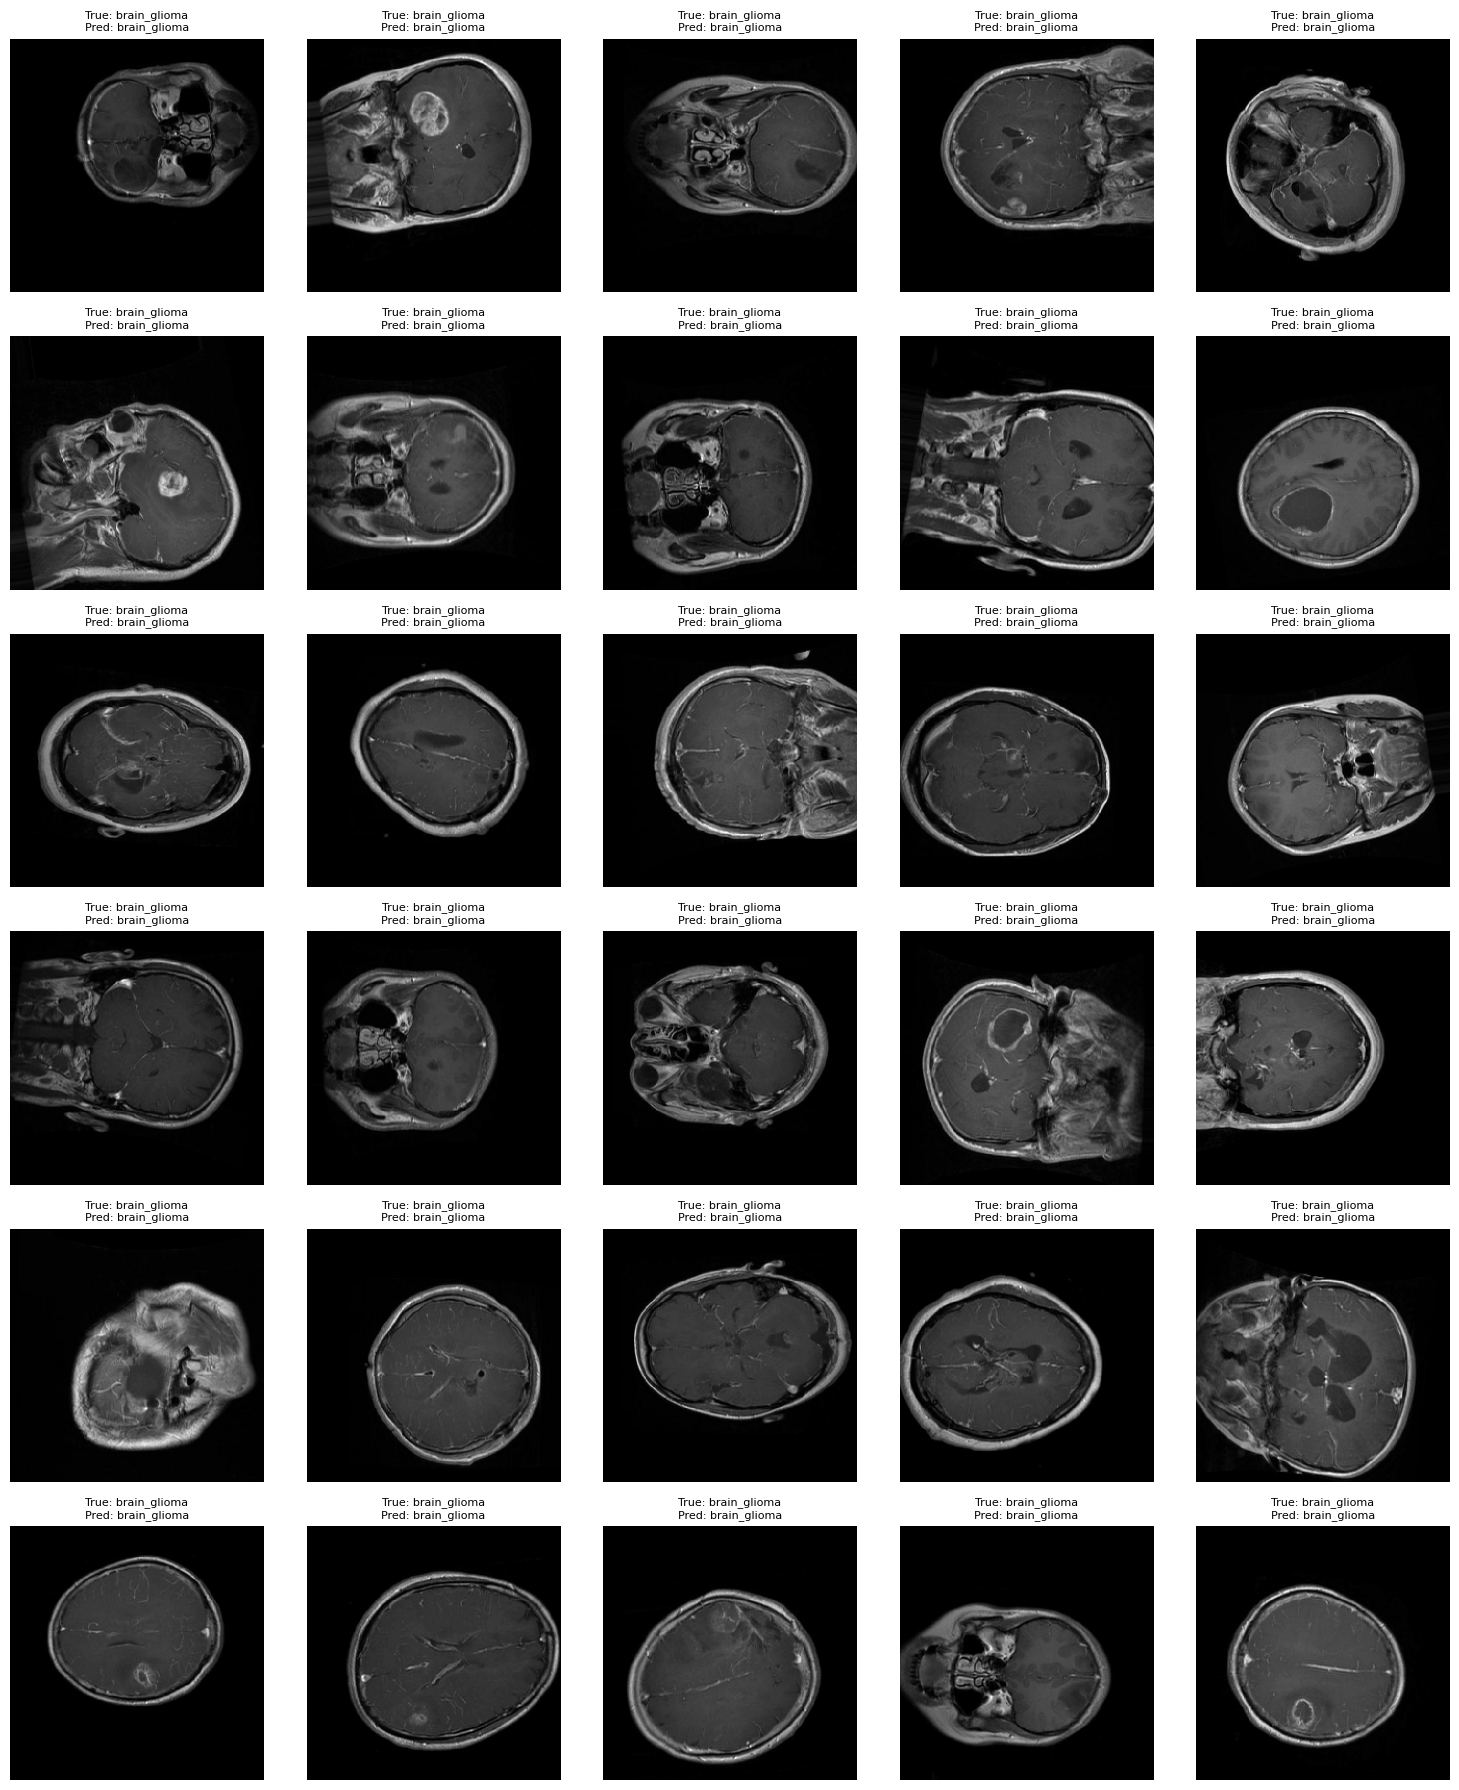

Overall - Precision: 0.9743, Recall: 0.9735, F1-Score: 0.9736
brain_glioma - Precision: 0.9975, Recall: 0.9850, F1-Score: 0.9912
brain_menin - Precision: 0.9844, Recall: 0.9450, F1-Score: 0.9643
brain_tumor - Precision: 0.9419, Recall: 0.9902, F1-Score: 0.9654


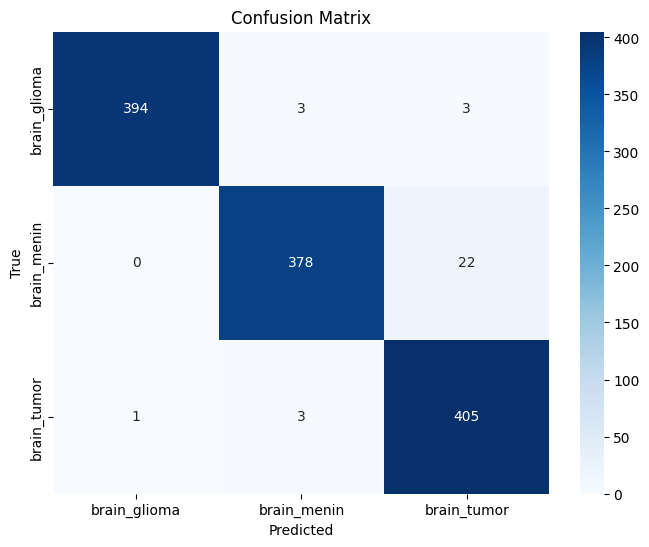

In [62]:

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
checkpoint = ModelCheckpoint('/kaggle/working/vgg16_brain_cancer_best.keras',
                            monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train
try:
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=test_generator,
        class_weight=class_weights,
        callbacks=[early_stopping, lr_reducer, checkpoint],
        verbose=1
    )
except Exception as e:
    print(f"Training failed: {e}")
    raise

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Visualize predictions
images_to_show = []
true_labels = []
pred_labels = []

test_generator.reset()
for i in range(30 // BATCH_SIZE + 1):
    images, labels = next(test_generator)
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    images_to_show.extend(images)
    true_labels.extend(true_classes)
    pred_labels.extend(predicted_classes)
    if len(images_to_show) >= 30:
        images_to_show = images_to_show[:30]
        true_labels = true_labels[:30]
        pred_labels = pred_labels[:30]
        break

class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(15, 18))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    img = images_to_show[i].squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.savefig('/kaggle/working/vgg16_predictions.png')
plt.show()

# Metrics
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

test_generator.reset()
y_true = []
y_pred = []
for i in range(len(test_generator)):
    images, labels = next(test_generator)
    predictions = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Overall - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

for i, class_name in enumerate(class_names):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    print(f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/vgg16_confusion_matrix.png')
plt.show()